In [27]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import stack, cat
import pandas as pd
from PIL import Image
import torch.cuda as cuda
import os

In [28]:
class ImageNetGenerator():
    class ImageNetDataset(Dataset):
        def __init__(self, grey_images_location, color_images_location, dataframe,grey_transform = None, color_transform = None):
            self.dataframe = dataframe
            self.grey_images_location = grey_images_location
            self.color_images_location = color_images_location
            self.grey_transform = grey_transform
            self.color_transform = color_transform

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            grey_path = os.path.join(self.grey_images_location, self.dataframe.loc[idx]['image'])
            grey_image = Image.open(grey_path)
            color_path = os.path.join(self.color_images_location, self.dataframe.loc[idx]['image'])
            color_image = Image.open(color_path)
            
            label = self.dataframe.loc[idx]['label']
            
            if self.grey_transform:
                grey_image = self.grey_transform(grey_image)
                
            if self.color_transform:
                color_image = self.color_transform(color_image)

            return (color_image,grey_image,label)
        
    def __init__(self, data_folder, grey=False):
        
        self.data_folder = data_folder
        
        
        self.grey_mean = [0.4508418102911656] # range 0-1
        #self.mean = [114.96465837522624] # range 0-255
     
        self.color_mean = [0.485, 0.456, 0.406]
        
        
        self.grey_std = [0.25920110984899464] # range 0-1
        #self.std = [66.096282163276186] # range 0-255
        
        self.color_std = [0.229, 0.224, 0.225]
        
        self.im_size = 224
     
        self.grey_transforms = transforms.Compose([
            transforms.CenterCrop(self.im_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.grey_mean,std=self.grey_std)
        ])
        
        self.color_transforms = transforms.Compose([
            transforms.CenterCrop(self.im_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.color_mean,std=self.color_std)
        ])
        
        self.dfs = {}
        for name in ["train","test","valid"]:
            file = os.path.join(self.data_folder,'{}.pkl.compress'.format(name))
            self.dfs[name] = pd.read_pickle(file, compression='gzip')
        self.datasets = {}
        self.grey_image_folder = os.path.join(self.data_folder,'squared_grey')
        self.color_image_folder = os.path.join(self.data_folder,'squared_color')
        
        for key,val in self.dfs.items():
            self.datasets[key] = self.ImageNetDataset(grey_images_location=self.grey_image_folder,
                                                      color_images_location=self.color_image_folder,
                                                      dataframe=val,
                                                      grey_transform=self.grey_transforms,
                                                      color_transform=self.color_transforms)
            
        self.index = pd.read_pickle(os.path.join(self.data_folder,'index.pkl.compress'), compression='gzip')
    
    def translate(self,label):
        return self.index[label]
        
    def get_loaders(self,batch_size=4,shuffle=True,num_workers=2):
        self.loaders = {}
        for key,val in self.datasets.items():
            self.loaders[key] = DataLoader( val,
                                            batch_size=batch_size, 
                                            shuffle=shuffle, 
                                            num_workers=num_workers)
        return self.loaders
    
    def plot_grey(self,tensor):
        temp = []
        for t, m, s in zip(tensor, self.grey_mean, self.grey_std):
                temp.append(t.mul(s).add(m))
        norm = stack(temp)
        return transforms.ToPILImage()(norm)

    def plot_color(self,tensor):
        temp = []
        for t, m, s in zip(tensor, self.color_mean, self.color_std):
                temp.append(t.mul(s).add(m))
        norm = stack(temp)
        return transforms.ToPILImage()(norm)
        

Using the grey parameter we can load a grey version of the Imagenet ILSVRC2012 validation dataset to fine tune our model. Don't forget that grey flag controls the normalization, but the image folder has to been set to "squared_grey" since images have been greyed in advance (and squared to save some space and have consistent dimensions).

In [29]:
#gen = ImageNetGenerator(data_folder = '/home/frati/Grasping/ImageNet/')

In [31]:
#loaders = gen.get_loaders(batch_size=32,shuffle=True,num_workers=8)

In [20]:
#print(len(gen.datasets['test']))
#print(len(loaders['test']))

4567
143


In [35]:
#color_images, grey_images, labels = next(iter(loaders['train']))

Ibizan hound, Ibizan Podenco


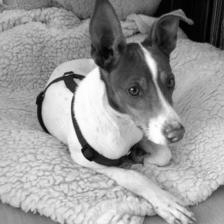

In [37]:
#el = 9
#print(gen.translate(labels[el]))
#gen.plot_grey(grey_images[el])

prison, prison house


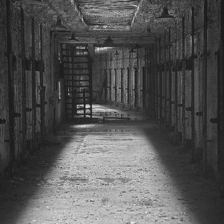

In [25]:
#print(gen.translate(labels[el]))
#gen.plot_color(color_images[el])